Pretrained networks used:

- INCEPTIONV3


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd "/content/drive/MyDrive/CI/"
!pip install import-ipynb

/content/drive/MyDrive/CI
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=3b53a9967a73a75607162288966db5ceaa4953410a797f276bc5d00baa1db0dc
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [3]:
import import_ipynb
import utility
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from tensorflow.keras import models,layers
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


data_path='/content/drive/MyDrive/CI/numpy_data/'

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ', device_name)

importing Jupyter notebook from utility.ipynb
Tensorflow Version: 2.4.1
GPU:  /device:GPU:0


# Data preprocessing


Building the dataset

In [4]:
images, labels = utility.load_training()

train_abnormal_imgs, train_abnormal_labels = utility.mass_calcification_training_set_building(images, labels)

print('Shape:',np.shape(train_abnormal_imgs))
print('Training Labels:', train_abnormal_labels)

(2676, 150, 150)
Shape: (2676, 150, 150)
Training Labels: [0 0 0 ... 1 1 1]


Building the test set

[0.  0.5 1. ]


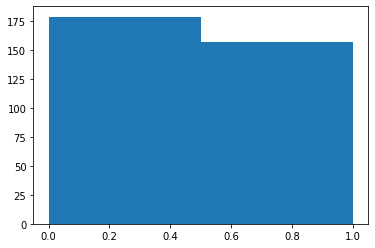

In [5]:
test_images, test_labels = utility.load_test()

test_mc_imgs, test_mc_labels = utility.mass_calficication_test_set_building(test_images, test_labels)

ax = plt.subplot(111)
n, bins, patches =ax.hist(test_mc_labels, bins=2)
print(bins)
plt.show()

dataset overview


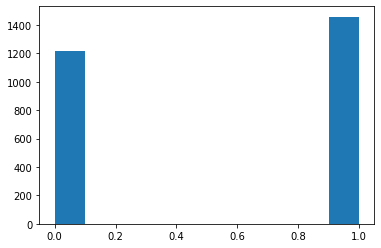

Mass Samples: 1218
Calcification Samples: 1458


In [6]:
plt.hist(train_abnormal_labels)
plt.show()
mass_samples = len([label for label in train_abnormal_labels if label == 0])
print('Mass Samples:', mass_samples)
calcification_samples = len([label for label in train_abnormal_labels if label == 1])
print('Calcification Samples:',calcification_samples)

1218
1458
Oversampling must be done on 240 elements of the first array.
Class 0: 1458
Class 1: 1458


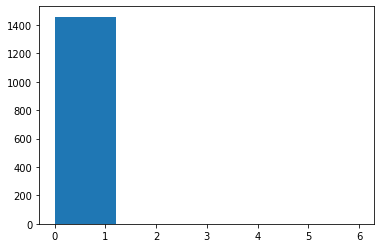

In [7]:
#balance the datset
num_zeros = (train_abnormal_labels == 0).sum()
num_ones = (train_abnormal_labels == 1).sum()

print(num_zeros)
print(num_ones)

train_mc_imgs, train_mc_labels= utility.oversample(train_abnormal_imgs,train_abnormal_labels)

plt.hist(train_mc_labels,range=(0,6) )
plt.show()

inceptionv3

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model

conv_base = InceptionV3(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(150, 150, 3),
                )

conv_base.trainable=False
conv_base.summary()


conv_base_last = Model(inputs=conv_base.input, outputs=conv_base.get_layer('mixed9').output)
conv_base_last.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [9]:
NORMALIZATION_VALUE = 65536
BATCH_SIZE = 32
train_samples_reshaped = np.expand_dims(train_mc_imgs,3)
test_samples_reshaped = np.expand_dims(test_mc_imgs,3)

val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_samples_reshaped, train_mc_labels, test_size=val_split, stratify=train_mc_labels)


train_datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)
test_datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)

train_generator = train_datagen.flow(X_train, 
                                     y=y_train, 
                                     batch_size=BATCH_SIZE, 
                                     seed=123)

validation_generator = train_datagen.flow(X_val, 
                                     y=y_val, 
                                     batch_size=BATCH_SIZE, 
                                     seed=123)


test_generator =  test_datagen.flow(test_samples_reshaped,
                                    y=test_mc_labels,
                                    batch_size=BATCH_SIZE,
                                    seed=123)

print('Training and Validation generated.')

Training and Validation generated.


In [10]:
model= models.Sequential()

model.add(tf.keras.Input(shape=(150,150,1)))
#DATA AUGMENTATION 
model.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123)) #paper 
model.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest')) #90degree

model.add(layers.Conv2D(3,(1,1),activation = 'relu'))
model.add(conv_base)
#model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))  #256 o 512
model.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 150, 150, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 150, 150, 3)       6         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [11]:
BATCH_SIZE = 32
EPOCHS =15

history = model.fit(train_generator,
          validation_data=validation_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

Epoch 1/15
73/73 [==============================] - 20s 118ms/step - loss: 0.6124 - accuracy: 0.7521 - val_loss: 0.3904 - val_accuracy: 0.8339
Epoch 2/15
73/73 [==============================] - 6s 85ms/step - loss: 0.3385 - accuracy: 0.8475 - val_loss: 0.3278 - val_accuracy: 0.8493
Epoch 3/15
73/73 [==============================] - 6s 85ms/step - loss: 0.3273 - accuracy: 0.8623 - val_loss: 0.3412 - val_accuracy: 0.8596
Epoch 4/15
73/73 [==============================] - 6s 85ms/step - loss: 0.3136 - accuracy: 0.8666 - val_loss: 0.2988 - val_accuracy: 0.8818
Epoch 5/15
73/73 [==============================] - 6s 87ms/step - loss: 0.3004 - accuracy: 0.8599 - val_loss: 0.3060 - val_accuracy: 0.8750
Epoch 6/15
73/73 [==============================] - 6s 87ms/step - loss: 0.2789 - accuracy: 0.8698 - val_loss: 0.3202 - val_accuracy: 0.8767
Epoch 7/15
73/73 [==============================] - 6s 88ms/step - loss: 0.2692 - accuracy: 0.8911 - val_loss: 0.3118 - val_accuracy: 0.8733
Epoch 8/15


In [12]:
dir_name ="/content/drive/MyDrive/CI/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name,'mc_inception_vx3.h5'))

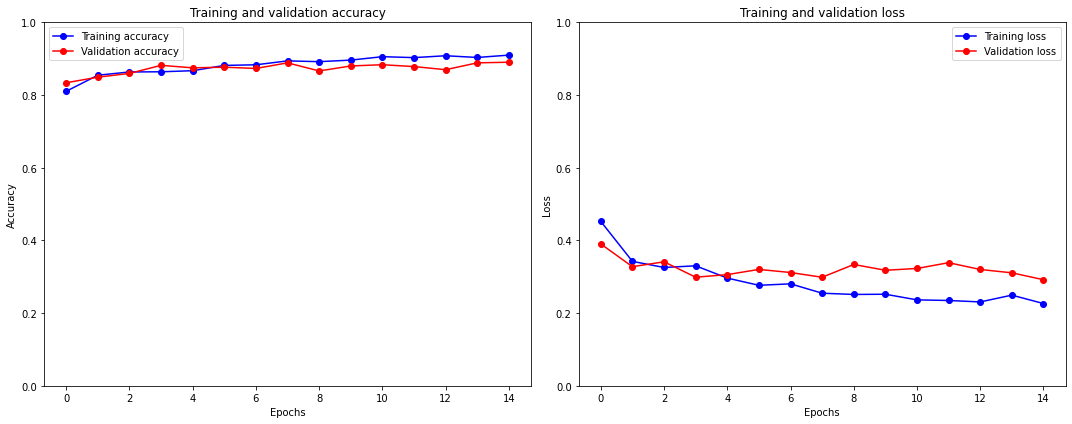

In [13]:
utility.plot_history(history,'mc_incemption_vx3.jpg')

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

11/11 [==============================] - 1s 74ms/step - loss: 0.3252 - accuracy: 0.8750
Test Accuracy: 0.875
Test Loss: 0.32518118619918823


Confusion matrix:
 [[166  13]
 [ 29 128]]

accuracy:
 0.875

f2:
 0.8322496749024707

report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       179
           1       0.91      0.82      0.86       157

    accuracy                           0.88       336
   macro avg       0.88      0.87      0.87       336
weighted avg       0.88      0.88      0.87       336

AUC:
 0.8713304629398997


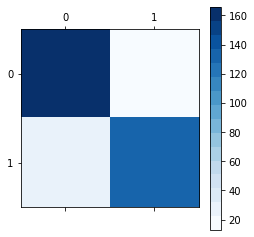

(0.8713304629398997, array([[166,  13],
        [ 29, 128]]), 0.875, 0.8322496749024707)

In [15]:
# ... or use predict() and sklearn to evaluate the model
test_set = test_samples_reshaped/65536
test_predictions = model.predict(test_set) 
utility.do_evaluations(test_predictions, test_mc_labels)